# Aperçu de quelques librairies pertinentes en python par l'exemple: les premiers blocks d'un moteur de recherche

Dans cet exemple, nous allons concevoir une application simple capable:
<ul>
<li> d'analyser le contenu de pages web
<li> distinguer le contenu textuel du reste des informations
<li> réaliser quelques analyses sémantiques de routine
<li> encoder les données dans un format aisément calculable pour la suite
<li> (opt.) analyser les images
</ul>

Cet exercice sera l'occasion d'utiliser certaines des principales librairies utilisées en Data Science. 
<ul>
<li> BeautifulSoup, un parser HTML <a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/">doc Officielle</a>
<li> Numpy, une librairie de calcul matriciel <a href="http://www.numpy.org/">doc Officielle</a>
<li> NLTK, une librairie pour le traitement automatisé du langage <a href="http://www.nltk.org/">doc Officielle</a>
<li> Pandas, une librairie orientée analyse de données (fera un peu penser à R pour les initiés) <a href="http://pandas.pydata.org/">doc Officielle</a>
<li> Seaborn, un outil de visualisation statistique <a href="https://seaborn.pydata.org/">doc Officielle</a>
<li> ainsi que diverses librairies pour optimiser notre script, lire et écrire les données en divers formats (CSV, JSON, etc)
</ul>

Commençons par importer tout ce joli petit monde

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from bs4 import BeautifulSoup

## Le Temps, cette ressource précieuse
Avant de commencer, j'aimerais débunker une croyance assez répandue, même au sein des devs, selon laquelle python serait, pour des raisons structurelles et inaccessibles, lent lourd et inefficient pour des applications à taille réelle. Deux niveau de réponses

Premièrement, ce problème n'est pas propre à Python mais concerne l'ensemble des langages de haut degré d'abstraction (trad "vous voulez du rapide, codez en C")

Deuxièmement, le problème ne provient pas tant du langage en lui-même que du fait que les opérations précises de l'interpréteurs ne nous étant pas accessibles, deux <b>implémentations différentes</b> de la même tâche peuvent demander un temps assez différent alors même qu'elle paraissent "conceptuellement identiques". 

Prenons un exemple en nous dotant tout d'abord d'un moyen de benchmarker nos opérations avant de chercher à optimiser notre code

In [2]:
from time import time
import math

def Benchmark(fonction): 
    start = time()
    fonction
    end = time()
    return (end - start)

In [ ]:
dataTest = np.random.rand(600000,3) # on génère 600000*3 points de données x,y,z (vecteur 2-D)
dataTestAsList = dataTest.tolist()  # on en fait une liste pour les besoins de l'exemple
print(dataTest)

Prenons une fonction un peu lourde à calculer pour comparer deux approches: l'une itérative, l'autre vectorisée

$f(x,y,z)= \frac{x^{2}-\sqrt{y}}{\sqrt{x+y}} \times z$

In [ ]:
resultsList = [] # on crée une liste vide
start = time() # on lance le chrono
for i in dataTestAsList:     # pour chaque ligne
    result = (i[0]**2-math.sqrt(i[1]))/math.sqrt(i[0]+i[1])*i[2] # fait le calcul
    resultsList.append(result)   # ajoute le résultat à la liste results
end = time() # on arrête le chrono

print("temps nécessaire: ",end - start)
print(resultsList[:15])          # on imprime les 15 premiers résultats
print(len(resultsList))

In [ ]:
x = dataTest[:,0] # premier vecteur = première colonne de la matrice
y = dataTest[:,1] # second vecteur = seconde colonne de la matrice
z = dataTest[:,2]

start = time() # on lance le chrono
results = np.multiply((np.power(x,2)-np.sqrt(y))/np.sqrt(np.sum((x,y), axis=0)),z)
end = time() # on arrête le chrono
print("temps nécessaire: ",end - start)
print(results)
print(len(results))

On voit assez aisément que, même pour ce petit dataset de trois valeurs x y z de 600000 points de donnée, l'<b>approche iterative</b> par les bloucles prend plus de 10 fois plus de temps que l'<b>approche vectorielle</b> permise par numpy pour le <b>même calcul</b>. Il existe une correpondance intuitive entre:
<ul>
<li> $a*b$ et np.multiply(a,b)
<li> $a**2$ et np.power(x,2)
<li> $a+b$ et np.sum((x,y), axis=0)
</ul>

Toutefois, lorsque a et b peuvent s'apparenter à des <b>vecteurs</b> de même longueur, du point de vue de l'interpréteur, cela fait une ÉNORME différence de réaliser les opérations de manière vectorielle plutôt qu'élément par élément (<i>element-wise</i>). La leçon a retenir est double: 
<ul>
<li> aussi souvent que possible, si vous le pouvez, <b>évitez de recourir à des boucles lorsque vous avez des données structurées</b>
<li> ce n'est pas parceque vous avec l'impression de décomposer une opération dans votre code que vous facilitez la tâche de l'interpréteur (il y a une couche d'abstraction entre son monde et le vôtre)
</ul>

Nous verrons en outre que la vectorisation n'est pas le seul moyen d'optimiser un code

## Constitution de notre set de données

Imaginez qu'un client (twitter, pour ne pas le nommer) vous commande un plugin web pour analyser toutes les pages indiquées en lien sur une chat box de son site propre. En gros, rien de bien sorcier, il veut pouvoir savoir rapidement de quoi la page parle, s'il y a des images, le ton général de l'article, s'il s'agit d'un page plutôt verbeuse, si elle parle de l'actualité ou au contraire d'événements anciens dans le but éventuel d'anlyser tout cela plus tard pour une analyse de marchée. Bref, un moyen de savoir ce dont il retourne sans avoir à tout lire.

Tout ce dont vous disposez, c'est d'un fichier CSV dont chaque ligne contient un post sur la chat box. 

On serait tenté d'importer ces données sous la forme d'une liste de chaîne de caractères sur laquelle appliquer les fonctions que nous allons importer ou créer. Ce serait toutefois ignorer notre précédente remarque sur les données structurées et la vectorisation. 

### Structuration et manipulation de données avec Pandas

Pour exploiter au mieux la structuration des données, nous allons les importer sous la forme d'un tableau de données (<i>dataframe</i>) avec la librairie pandas



In [ ]:
data = pd.read_csv("chatbox.csv",sep=',')
print(type(data))

print(data.head())

$data$ est un objet de type particulier, doté de ses propres attributs et méthodes (ex. $head()$ pour avoir les premières lignes du tableau). Par défaut, $read_csv$ utilise la première ligne comme le nom des colonnes. Regardons ces données de plus près. 

In [ ]:
print("champs de données (colonnes): ",list(data))
print("nombre de lignes: ", len(data))
print(data.describe())

Il est assez simple de sélectionner des colonnes spécifiques ou de spliter un tableau en fonction de la valeur dans un champ donné. Prenons le cas des messages "likés" au moins une fois. 

In [ ]:
data["liked"] # la colonne liked du tableau
dataLiked = data[(data["liked"]!=0)] # partie des données dont liked diffère de zero

print("nombre de lignes: ", len(dataLiked))

114223 messages pour seulement 25252 likés. Ça donne une idée des eusses et coutumes de cette chatbox. La methode de subseting peut paraître déconcertante au premier abord avec cet enchassement $[()]$. Retenez simplement que, en pandas, $[]$ permet de subseter, $()$ énonce une condition. 

Mainenant que nous avons vu les données, il faut que nous extrayons les urls du champ $"text"$. Pour cela, pas besoin de tirer la mouche au canon, une simple analyse d'expression régulière (oui, du Regex !) suffit. Une url n'est jamais rien d'autre qu'
<ul>
<li> une chaine de caractère
<li> ne contenant pas d'espace
<li> commençant par "http"
</ul>

Comme précédemment, nous pourrions extraire chaque ligne de $data$, analyser chaque $text$ à l'aide d'une bloucle: 

In [ ]:
import re # librairie de référence pour le Regex

Text = data["text"].tolist() # on crée une liste 
print(type(Text))

urls = []
start = time() # on lance le chrono
for i in Text:
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', i)
    if url != '':
        urls.append(url)
end = time() # on arrête le chrono
print("temps nécessaire: ",end - start)

print(urls[:15])


Essayons maintenant avec une methode built-in. Nous introduisons une nouvelle colonne de données appelée $urls$

In [ ]:
start = time() # on lance le chrono
data['urls'] = data['text'].str.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+') # get the urls
end = time() # on arrête le chrono
print("temps nécessaire: ",end - start)

print(data.head())

Maintenant que nous avons notre champ $"urls"$, concentrons nous exclusivement sur les posts qui renvoient à des liens externes. Le principe reste le même à quelques ajustement près. $"urls"$ contient pour l'instant des listes de <b>str</b> ce qui risque de nous faire un peu chier pour la suite. Nous allons considérer que seul le premier lien nous intéresse et changer le type des données de $"urls"$ de <b>list</b> à <b>str</b>. Vérifions d'abord qu'il s'agit bien de listes:  

In [ ]:
print(type(data["urls"]))
print(data["urls"].head())

Bon, ça risque d'être un peu chiant. Essayons autrement

In [ ]:
data['urls'] = data['urls'].astype(str)  # on en fait une chaîne de caractère et on va virer les caractères problématiques

data['urls'] = data['urls'].str[1:] # on vire le premier caractère ([)
data['urls'] = data['urls'].str[:-1] # on vire le dernier caractère (])
data['urls']

C'est mieux, nous avons maintenant des champs de données vides => nous allons pouvoir faire un subsetting

In [ ]:
dataUrl = data[(data['urls']!='')]
print(dataUrl['urls'].head(25))
print(len(dataUrl['urls']))

Affinons encore. Pour prendre uniquement la première url, il suffit de virer ce que nous avons après ","

In [ ]:
dataUrl['urls'].astype(str)
print(dataUrl['urls'].head(25))
dataUrl['urls'] = dataUrl['urls'].astype(str).str.split(',').str[0]
print(dataUrl['urls'])

Dernier coup de reins, on vire les " et les '

In [ ]:
dataUrl['urls'] = dataUrl['urls'].str.replace('"','')
dataUrl['urls'] = dataUrl['urls'].str.replace("'","")

print(dataUrl['urls'].head(25))

Bien, nous avons nos urls bien propres. On jette un dernier regard à notre set de données final avant de le sauvegarder dans un fichier JSON. 

In [ ]:
print(dataUrl.head(30))
dataUrl.to_json("talkboxUrl.json")


## Raffinement de données: identification des véritables urls

Pour développer nos fonctions, nous allons prendre quelques une des urls du dataset

In [ ]:

urlsTest = dataUrl['urls'].sample(10).tolist()
print(urlsTest)

In [ ]:
import webbrowser as wb

for url in urlsTest: 
    wb.open(url)

Le code qui précède doit avoir ouvert 10 nouveaux onglets dans le navigateur par défaut. Nous pouvons maintenant nous rendre compte que nous avons à boire et à manger. En l'occurrence, les liens peuvent se classer en deux catégories: 
<ul>
<li> liens pointant sur des posts de réseaux sociaux (e.g. twitter, mais pas seulement) <b>ne nous intéressent pas</b> (e.g. https://t.co/EbtX7NPvJb)
<li> liens pointant sur autre chose que des réseaux sociaux <b>ceux qui nous intéressent </b> (e.g. https://t.co/s6vf7joplx)
</ul>

Le problème, c'est que les urls dont nous disposons sont des urls raccourcies par le serveur de la chatbox => le <b>nom de domaine</b> n'est pas immédiatement lisible dans nos données. Il nous faut un moyen simple <b>et rapide</b> de récupérer les noms de domaines pour ne garder que ce qui nous intéresse.

Il existe une bonne librairie pour le faire en python: <a href="http://docs.python-requests.org/en/master/">requests</a>

In [ ]:
import requests
r = requests.get('https://t.co/EbtX7NPvJb')

print(r.url)
print(r.status_code)

Bon, appliquons cela sur l'intégralité de la base de données

In [ ]:
dataUrl['urls'] = dataUrl['urls'].requests.get('https://t.co/EbtX7NPvJb').url
dataUrl['urls'] = dataUrl['urls'].str.requests.get('https://t.co/EbtX7NPvJb').url

Bouh sniff, Bouh sniff, ça ne marche pas. Pourquoi? Parce que nous sommes en train de demander à python d'appliquer une méthode sur un type d'objet non prévu pour. Il nous faut penser la chose différemment avec la methode <b>apply</b>

In [ ]:
def GetRealUrl(url):           # on crée une fonction pour récupérer les urls et les éventuels codes d'erreur
    try:
        response = requests.get(url)

        # Consider any status other than 2xx an error
        if not response.status_code // 100 == 2:
            return "Error: Unexpected response {}".format(response)
        
        return response.url
    except requests.exceptions.RequestException as e:
        # A serious problem happened, like an SSLError or InvalidURL
        return "Error: {}".format(e)

urlsTest = dataUrl['urls'].sample(60).tolist()    

start = time()
for url in urlsTest: # regardons ce qu'elle donne
    print(GetRealUrl(url))
end = time() # on arrête le chrono
print("temps nécessaire: ",end - start)

Bon, nous sommes un peu dans la m*: à peu près 60s pour 60 urls => 60000 secondes pour tout le data set => 16 heures pour tout vérifier. Damned. Juste pour s'en assurrer, le problème vient-il de la boucle?

In [ ]:
dataUrlTest = dataUrl.sample(60)

start = time()
dataUrlTest['urls'] = dataUrlTest['urls'].apply(lambda x: GetRealUrl(x))
end = time() # on arrête le chrono
print("temps nécessaire: ",end - start)

print(dataUrlTest['urls'])

Le gain est vraiment marginal. Ça n'a rien d'étonnant puisque le principal bottleneck, ici, ce n'est pas le <b>calcul</b> mais le <b>temps nécessaire à chaque requête</b> (envoi de la requête, réponse du serveur); paramètre sur lequel nous n'avons pas vraiment de contrôle. 

Il pourrait être pas mal de nous doter d'un moyen de passer plusieurs requêtes simultanément et ainsi ne pas avoir à attendre la réponse de la requête Rn avant d'envoyer la requête Rn+1. Il nous faut paralléliser nos opérations. 

## La parallélisation en Python: multithreading VS multiprocessing

Il faut bien distinguer deux choses.
<ul>
<li> multithreading : multiples opérations passées au même core CPU: ce sont les opérations de lecture et d'écriture (<i>IO operation</i>) qui sont multipliées
<li> multiprocessing: parallélisation au niveau du CPU lui même (usage de tous les coeurs)
</ul>

Ici, avec nos requêtes, le problème n'est pas computationnel => un simple multithreading ferait le boulot. Toutefois, la méthodologie de la librairie multi-processing de python s'est considérablement simplifié ces dernières années au point qu'il est devenu plus simple de l'utiliser dans tous les contextes. (voir <a href="http://chriskiehl.com/article/parallelism-in-one-line/"> cet article </a> à titre de comparaison avec les exemples que l'on retrouve traditionnellement).  Sachant que l'ordre d'exécution et la synchronisation ne nous intéresse pas, nous allons nous contenter d'une simple <b>pool</b> et d'un mapping. 

In [ ]:
from multiprocessing.dummy import Pool as ThreadPool 

In [ ]:
dataUrlTest = dataUrl.sample(60) # on réinitialise (histoire de ne pas travailler sur des données déjà rafinées)
pool = ThreadPool(4) # on crée 4 tâches parallèles

start = time()
dataUrlTest['urls'] = pool.map(GetRealUrl, dataUrlTest['urls'])
pool.close() 
pool.join()

end = time() # on arrête le chrono
print("temps nécessaire: ",end - start)
print(dataUrlTest['urls'])

That was impressive: on passe de 60 secondes à un peu plus de 5 secondes pour 60 urls. Naivement, on peut s'attendre à 5000 secondes => une petite heure et demi pour tout vérifier. Peut-on faire encore mieux?

Dépend des cas: ici, clairement! On pourrait penser que le nombre optimal de <b>Thread</b> à mettre dans la <b>pool</b> correspond au <b>nombre de coeurs du processeur</b>. Tel serait le cas pour une tâche computationnellement plus lourde (nous serons amené à y revenir) mais pas ici. 

In [ ]:
dataUrlTest = dataUrl.sample(20000) # on réinitialise (histoire de ne pas travailler sur des données déjà rafinées)

pool = ThreadPool(30) # on crée 30 tâches parallèles

start = time()
dataUrlTest['urls'] = pool.map(GetRealUrl, dataUrlTest['urls'])
pool.close() 
pool.join()

end = time() # on arrête le chrono
print("temps nécessaire: ",end - start)
print(dataUrlTest['urls'])

Maintenant, on vire les "Error" et les liens pointant vers les réseaux sociaux

In [ ]:
dataUrlTest2 = dataUrlTest

dataUrlTest2 = dataUrlTest2[~dataUrlTest2["urls"].str.startswith("Error")]
dataUrlTest2 = dataUrlTest2[~dataUrlTest2["urls"].str.startswith("https://twitter.com")]
dataUrlTest2 = dataUrlTest2[~dataUrlTest2["urls"].str.startswith("https://www.facebook.com")]
dataUrlTest2 = dataUrlTest2[~dataUrlTest2["urls"].str.startswith("https://www.instagram.com")]
dataUrlTest2 = dataUrlTest2[~dataUrlTest2["urls"].str.startswith("https://www.pinterest.com")]



#dataUrlTest = dataUrlTest[~dataUrlTest.urls.str.startswith('Error')]

#dataUrlTest
print(dataUrlTest2.head(15))

print(dataUrlTest2.count)



In [ ]:
dataUrlTest2.to_json("talkboxUrlRefined.json")

## Le parsing, enfin

In [ ]:
dataset = pd.read_json("talkboxUrlRefined.json")
print(dataset.head())

Prenons une des urls de notre set 

In [ ]:
from urllib.request import Request, urlopen

urlTest = Request("https://beinglibertarian.com/need-fix-libertarian-national-convention/", headers = {'User-Agent': 'Mozilla/5.0'})  # un moyen un peu hacky d'éviter une erreur 403
page = urlopen(urlTest).read()
pageStr = BeautifulSoup(page, "lxml")
print(pageStr)

C'est un peu sale pour l'instant mais nous allons pouvoir exploiter, assez facilement, la structuration de la page. Nous sommes surtout intéressés par les données textuelles (titres, titres de sections (h1, h2, h3), contenu des paragraphes), les images, la longueur globale du contenu. En outre, il pourrait être intéressant de récupérer la langue pour la suite (et s'éviter de faire du NLP sur autre chose que de l'anglais)
![HTML structure](http://www.openbookproject.net/tutorials/getdown/css/images/lesson4/HTMLDOMTree.png)

Commençons par voir comment récupérer ces données avec BeautifulSoup avant de concevoir notre fonction

In [ ]:
titrePrin = pageStr.title.get_text()  # titre de la page
print(titrePrin)
print(type(titrePrin))

titresSect = [title.get_text() for title in pageStr.findAll(('h1','h2','h3','h4','h5'))]
#print(titresSect) # titre de la page

textualCont = [content.get_text() for content in pageStr.findAll('p')]
print(textualCont)
print(type(textualCont))

links= [link.get('href') for link in pageStr.findAll('a') if str(link.get('href')).startswith(("http", "www"))]
#print(links)

pics= [pic.get('src') for pic in pageStr.findAll('img') if pic.get('alt') !=""]
#print(pics)

In [ ]:
def ParseUrl(l):
    
    url = Request(l,headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36"})  # un moyen un peu hacky d'éviter une erreur 403
    try:
        page = urlopen(url).read()
    except:
        return pd.Series(['Nan','Nan','Nan','Nan','Nan'])
    pageStr = BeautifulSoup(page, "lxml")
    titresSect = [title.get_text() for title in pageStr.findAll(('h1','h2','h3','h4','h5'))]# récupère le texte dans ts les balises <h*>
    textualCont = [content.get_text() for content in pageStr.findAll('p')] # récupère le texte dans ts les balises <p>
    links= [link.get('href') for link in pageStr.findAll('a') if str(link.get('href')).startswith(("http", "www"))] # récupère les liens dans ts les balises <a> si href commence par "http" ou "www"
    pics= [pic.get('src') for pic in pageStr.findAll('img') if pic.get('alt') !=""] # récupère les liens dans ts les balises <img> ssi alt non nul 
    return pd.Series([titresSect,textualCont,links,pics])

In [ ]:
SubsetforTest = dataset.sample(20)

In [ ]:
start = time()

pool = ThreadPool(4)

a = pool.map(ParseUrl, SubsetforTest["urls"]) # applique de manière parallèle la fonction ParseUrl à SubsetforTest["urls"] 
a = pd.DataFrame(a)   # converti la fonction ainsi obtenue en un dataFrame
a = a.rename(columns = {0:"titreSect",1:"textualCont", 2:"links", 3:"pics"}) # dont on note les colonnes
SubsetforTest  = SubsetforTest.reset_index() # on remet les index de SubsetforTest à 0 (pour être aligné avec les index de a)
result = pd.concat([SubsetforTest, a], axis=1) #on concatène les deux dataFrame

pool.close() 
pool.join()

end = time() # on arrête le chrono
print("temps nécessaire: ",end - start)

In [ ]:
a

In [ ]:
result 

In [ ]:
DataShort = dataset.sample(3000) # subset parsable en moins d'une heure (nous allons nous en contenter)

In [ ]:
start = time()

pool = ThreadPool(4)

a = pool.map(ParseUrl, DataShort["urls"]) # applique de manière parallèle la fonction ParseUrl à DataShort["urls"] 
a = pd.DataFrame(a)   # converti la fonction ainsi obtenue en un dataFrame
a = a.rename(columns = {0:"titreSect",1:"textualCont", 2:"links", 3:"pics"}) # dont on note les colonnes
DataShort  = DataShort.reset_index() # on remet les index de DataShort à 0 (pour être aligné avec les index de a)
resultParsed = pd.concat([DataShort, a], axis=1) #on concatène les deux dataFrame

pool.close() 
pool.join()

end = time() # on arrête le chrono
print("temps nécessaire: ",end - start)

In [ ]:
resultParsed.head(15)

In [ ]:
resultParsed.to_csv("talkboxParsed.csv")

In [3]:
data = pd.read_csv("talkboxParsed.csv")

In [ ]:
print(data.iloc[5]["textualCont"])

## NLP: Finally

Maintenant que nous disposons de nos données, formatées et "nettoyées", nous allons pouvoir analyser pour chaque lien le contenu sémantique des données textuelles. La librairie de référence pour le faire en python s'appelle <a href="http://www.nltk.org/"> NltK </a>. Nous n'allons ne nous contenter que de quelques opérations basiques pour commencer (le but à terme étant de réaliser des sentiment analysis)

### premier pas avec NLTK
NltK travaille sur des chaines de caractère et dispose de fonctions pour (entre autre)
<ul>
<li> tokenizer des chaines de charactères (<a href="http://www.nltk.org/api/nltk.tokenize.html">voir les méthodes</a>) 
<li> 
</ul>

Nous allons d'abord importer les corpora necessaires

In [4]:
import nltk

In [ ]:
nltk.download()

Voyons maintenant ce que nous pouvons aisément faire sur un texte comme celui ci.

In [ ]:
text = "Yet it was watching him, with its beautiful marred face and its cruel smile. Its bright hair gleamed in the early sunlight. Its blue eyes met his own. A sense of infinite pity, not for himself, but for the painted image of himself, came over him. It had altered already, and would alter more. Its gold would wither into gray. Its red and white roses would die. For every sin that he committed, a stain would fleck and wreck its fairness. But he would not sin. The picture, changed or unchanged, would be to him the visible emblem of conscience. He would resist temptation." # Oscar Wilde The Picture of Dorian Grey  chap 5

# La première chose à faire consiste à identifier les mots individuellement (car les espaces ne suffisent pas)

tokenized = nltk.word_tokenize(text)
print(tokenized)
print(type(tokenized))

print("#########")

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
lem = [wnl.lemmatize(t) for t in tokenized]
print(lem)

print("#########")

tagged = nltk.pos_tag(tokenized)
print(tagged)
print(type(tokenized))


Nous pouvons même nous essayer à quelques analyses lexicographiques. Une fonction beaucoup utilisée pour évaluer rapidement le message d'un text consiste à analyser l'ensemble de ses n-grams à la recherche de n-grams récurrents (aussi appelés <b>collocations</b>). (n-grams = séquence continu de n mots adjacents dans un text)

NB (ce n'est pas si fantaisiste et désuet que cela puisque <a href="http://storage.googleapis.com/books/ngrams/books/datasetsv2.html">même Google le fait sur ses livres</a>)

Nous allons utiliser directement les fonctions de recherche de collocation de NLTK 


In [ ]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
bigram_measures= BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(tokenized, window_size = 3) # on cherche tous les bigrams dans une fenêtre de 3 mots
best = finder.nbest(bigram_measures.pmi,20) # on prend les 20 meilleurs
print(best)

Ce n'est peut être pas très parlant à l'échelle d'un texte si court, choisissons quelque chose de plus long

In [ ]:
from nltk.corpus import gutenberg

nouvelle = gutenberg.words('shakespeare-hamlet.txt')
nouvelle

finder = BigramCollocationFinder.from_words(nouvelle, window_size = 4) # on cherche tous les bigrams dans une fenêtre de 3 mots
best = finder.nbest(bigram_measures.pmi,20) # on prend les 20 meilleurs
print(best)

Nous allons plutôt nous intéresser aux analyses de sentiments avec le module sentiment de NltK

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

paragraph = "It was one of the worst movies I've seen, despite good reviews. \ Unbelievably bad acting!! Poor direction. VERY poor production. \ The movie was bad. Very bad movie. VERY bad movie. VERY BAD movie. VERY BAD movie!"


sid.polarity_scores(paragraph)

/home/dav/.local/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


{'compound': -0.9921, 'neg': 0.609, 'neu': 0.391, 'pos': 0.0}

C'est pas mal, ça!!! Essayons avec autre chose

In [ ]:
phrase1 = "VADER is smart, handsome, and funny!"
phrase2 = "VADER is VERY SMART, handsome, and FUNNY!!!"
text2 = "It was one of the worst movies I've seen, despite good reviews. VADER is VERY SMART, handsome, and FUNNY!!!"

print(sid.polarity_scores(phrase1))
print(sid.polarity_scores(phrase2))
print(sid.polarity_scores(phrase1 + " " +phrase2))
print(sid.polarity_scores(text2))

Nous disposons maintenant des quelques outils nécessaires à traiter nos données

## Maintenant, nos données

Nous allons concevoir des fonctions pour calculer les données suivantes
<ul>
<li> polarity tweet: polarité du contenu du tweet (nous allons utiliser le .polarity_scores de Vader)
<li> polarity url: la polarité du contenu de la page en lien
<li> imageRatio: le ratio du nombre d'image par rapport à la longueur des données textuelles
</ul>

Idéalement, si cela est possible avec la méthode pool map, nous parallèliserons les opérations pour tirer pleinement parti de nos machines hors de prix :)

In [38]:
SubsetForTest = data.sample(100)
from multiprocessing.dummy import Pool as ThreadPool 

In [41]:
print(SubsetForTest)

      Unnamed: 0   index              created  followers  friends  \
148          148  113679  2017-02-08 18:52:43        187       50   
380          380  113533  2017-02-08 18:58:07         22       16   
343          343   85751  2017-02-07 23:01:15       3879     3998   
1322        1322   40600  2017-03-07 17:28:04       4286     3716   
1138        1138  111837  2017-02-08 20:02:47        373     1100   
331          331   79254  2017-02-08 04:33:47        102      136   
1220        1220  102855  2017-02-07 09:54:58        710      315   
824          824   21860  2017-02-28 20:03:06       2551      850   
2022        2022   22208  2017-02-28 17:53:45        940     1386   
2067        2067   74648  2017-02-08 10:55:25        462      948   
1853        1853   27134  2017-02-26 16:49:07        323      432   
2441        2441   22280  2017-02-28 17:21:45       2006      307   
249          249   54942  2017-03-02 12:06:48         46      112   
2644        2644   56383  2017-03-

In [42]:
def GetPolarity(t): # il vaudrait mieux n'avoir qu'une valeur: neg pour neg et pos pour pos (ce sera plus simple à ploter)
    polarity =sid.polarity_scores(t)
    return(polarity["pos"] - polarity["neg"])

def GetPolarityVerbose(t): # il vaudrait mieux n'avoir qu'une valeur: neg pour neg et pos pour pos (ce sera plus simple à ploter)
    polarity =sid.polarity_scores(t)
    return(polarity)

def ImageRatio(u,v):
    return(math.log(len(u)/len(v)))

In [43]:
start = time()
pool = ThreadPool(4) # on crée 4 tâches parallèles

SubsetForTest["polarityUrl"] = pool.map(GetPolarity, SubsetForTest["textualCont"])
SubsetForTest["polarityUrlV"] = pool.map(GetPolarityVerbose, SubsetForTest["textualCont"])

SubsetForTest["polarityTweet"] = pool.map(GetPolarity, SubsetForTest["text"])
SubsetForTest["polarityTweet"] = pool.map(GetPolarityVerbose, SubsetForTest["text"])

pool.close() 
pool.join()

SubsetForTest["imageRatio"] = SubsetForTest.apply (lambda row: ImageRatio(row["textualCont"], row["pics"]),axis=1)

end = time() # on arrête le chrono
print("temps nécessaire: ",end - start)

temps nécessaire:  9.027629137039185


In [32]:
SubsetForTest["nbUrl"]

119      1808
235         3
63      14729
598     19328
1003      869
2085     9640
1307     3028
1563      267
1763     1422
295      3730
Name: nbUrl, dtype: int64

In [37]:
len(data)

3000

In [46]:
start = time()
pool = ThreadPool(4) # on crée 4 tâches parallèles

data["polarityUrl"] = pool.map(GetPolarity, data["textualCont"])
data["polarityUrlV"] = pool.map(GetPolarityVerbose, data["textualCont"])

data["polarityTweet"] = pool.map(GetPolarity, data["text"])
data["polarityTweetV"] = pool.map(GetPolarityVerbose, data["text"])

pool.close() 
pool.join()

data["imageRatio"] = data.apply (lambda row: ImageRatio(row["textualCont"], row["pics"]),axis=1)

end = time() # on arrête le chrono
print("temps nécessaire: ",end - start)

temps nécessaire:  397.8306622505188


In [45]:
data

,Unnamed: 0,index,created,followers,friends,hashtag,liked,location,retwc,text,urls,titreSect,textualCont,links,pics,4,polarityUrl,polarityUrlV,polarityTweet,imageRatio
0,0,82045,2017-02-08 02:04:14,95,378,None,0.0,NaN,4,b'RT @canadianliving: Let them eat (vegan) cak...,http://www.canadianliving.com/food/recipe/dark...,"['Follow us!', 'Login', 'Connect with', 'Sign ...","['Sign Up For Our Newsletters', 'Sign Up For O...","['http://groupetva.ca/', 'http://tva.canoe.ca/...",['http://static.assets.groupetva.ca/groupetva/...,NaN,0.096,"{'neg': 0.009, 'compound': 0.9242, 'neu': 0.88...","{'neg': 0.0, 'compound': 0.0, 'neu': 1.0, 'pos...",-0.540122
1,1,108256,2017-02-07 03:10:38,23,68,vegan,0.0,NaN,0,b'This vegetarian chili topped with cheesy cor...,http://gatorato.com/video/cheesy-cornbread-top...,"['Cheesy Cornbread-Topped Chili', 'Vegetarian ...","['Here is what you’ll need!', 'Cheesy Cornbrea...","['http://gatorato.com', 'https://www.facebook....",['http://gatorato.com/wp-content/uploads/2016/...,NaN,0.047,"{'neg': 0.0, 'compound': 0.7955, 'neu': 0.953,...","{'neg': 0.0, 'compound': 0.0, 'neu': 1.0, 'pos...",2.740840
2,2,18615,2017-02-11 12:43:14,4748,4704,None,1.0,NaN,0,b'How Milo and the Free Speech Libertarian Mov...,http://potusnewss.ml/6bg,[],"['Report Malicious Advert', 'Warning!', 'It ap...","['http://potusnewss.ml', 'http://potusnewss.ml...",['http://potusnewss.ml/static/image/logo_fb2.p...,NaN,0.045,"{'neg': 0.034, 'compound': 0.3382, 'neu': 0.88...","{'neg': 0.0, 'compound': 0.6369, 'neu': 0.698,...",0.382854
3,3,7455,2017-02-15 17:09:53,475,88,None,0.0,NaN,23,b'RT @JacobEngels: Anti-Hillary rap group @Fre...,http://eastorlandopost.com/anti-hillary-rap-gr...,"['East Orlando Post', 'Search form', '\n ...","['\n', 'Alternative hip hop group Freenauts, a...","['https://www.facebook.com/freenauts/', 'https...",['http://eastorlandopost.com/sites/default/fil...,NaN,0.095,"{'neg': 0.048, 'compound': 0.9952, 'neu': 0.80...","{'neg': 0.0, 'compound': 0.2942, 'neu': 0.88, ...",2.054881
4,4,52262,2017-03-03 07:52:51,7879,2748,libertarian,0.0,NaN,0,b'https://t.co/pd36U8Avkf BBC - Bitcoin tops g...,http://www.bbc.com/news/business-39149475,"['Accessibility links', 'BBC navigation', 'New...","['', 'Share this with', 'Email', 'Facebook', '...",['https://account.bbc.com/account?ptrt=http%3A...,['http://static.bbci.co.uk/frameworks/barlesqu...,NaN,0.026,"{'neg': 0.064, 'compound': 0.8957, 'neu': 0.84...","{'neg': 0.0, 'compound': 0.5562, 'neu': 0.582,...",2.742965
5,5,26307,2017-02-26 23:03:09,1723,1905,None,0.0,NaN,0,b'Libertarian Think Tank Cato Institute Proves...,https://trofire.com/2017/02/26/libertarian-thi...,['Libertarian Think Tank Proves That Trump’s M...,['The Libertarian Cato Institute released a st...,"['https://trofire.com/', 'https://trofire.com/...",['https://www.trofire.com/wp-content/uploads/2...,NaN,-0.108,"{'neg': 0.184, 'compound': -0.9987, 'neu': 0.7...","{'neg': 0.205, 'compound': -0.5574, 'neu': 0.7...",2.044295
6,6,99650,2017-02-07 14:00:06,85255,12820,recipe,3.0,NaN,1,b'Savory Broccoli Pancakes with Vegan Ricotta ...,https://www.wholefoodsmarket.com/recipe/savory...,"['Main navigation', 'Savory Broccoli Pancakes ...","['Check out our top pins!', ""Note: We've provi...","['https://twitter.com/share', 'https://www.who...",['https://www.wholefoodsmarket.com/sites/all/t...,NaN,0.078,"{'neg': 0.0, 'compound': 0.8684, 'neu': 0.922,...","{'neg': 0.0, 'compound': 0.0, 'neu': 1.0, 'pos...",1.107690
7,7,110114,2017-02-07 01:46:59,4188,4826,GIVEAWAY,0.0,NaN,618,b'RT @PuritansPride: #GIVEAWAY: RT &amp; follo...,https://www.puritan.com/vegetarian-662?scid=26...,"['Shop By Category', 'Shop By Health Concern',...","['\nView Pill Size Chart\xa0»\n', ""\n ...","['http://blog.puritan.com', 'https://www.faceb...",['//images.vitaminimages.com/pp/images/checkou...,NaN,0.080,"{'neg': 0.049, 'compound': 0.9858, 'neu': 0.82...","{'neg': 0.0, 'compound': 0.7783, 'neu': 0.672,...",1.314704
8,8,95272,2017-02-07 17:23:13,2727,3676,GIVEAWA

In [47]:
data.to_csv("dataFinal.csv")

## Visualisation et analyse de nos données

Maintenant que nous disposons des variables nécessaires, vient le moment de visualiser (nous allons pour cela nous servir de <a href ="https://matplotlib.org/">matplotlib</a>) d'identifier d'éventuelles corrélations. Commençons par la polarité des tweet et des articles. Il ne serait pas étonnant que l'une explique l'autre.

NB: nous n'avons maintenant plus que 3000 points de données (celle contenant des urls que nous avons pu parsé) => ne vous attendez pas à un miracle sur la portée des conclusions que nous pourrons tirer


In [57]:
import matplotlib.pyplot as plt
import scipy
plt.style.use('seaborn')

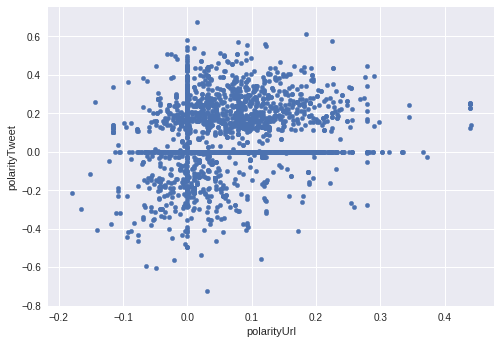

SpearmanrResult(correlation=0.17900364353788348, pvalue=5.0706890426468036e-23)

In [58]:
CorrPol = scipy.stats.spearmanr(data["polarityUrl"], data["polarityTweet"], axis=0)

data.plot("polarityUrl", "polarityTweet",kind ="scatter")
plt.show()
CorrPol

Nous avons une faible corrélation entre la polarité des tweets et la polarité de liens indiqués dans ces tweets; faible mais significative. Essayons de virer les tweets neutres (non polarisés) pour y voir plus clair

In [60]:
dataPolar = data[(data["polarityTweet"]!= 0)]

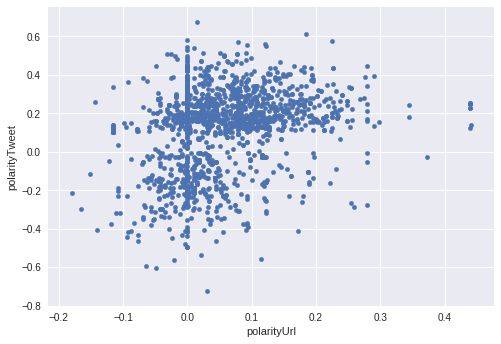

SpearmanrResult(correlation=0.23908580810633989, pvalue=1.2016306326209924e-26)

In [64]:
CorrPol = scipy.stats.spearmanr(dataPolar["polarityUrl"], dataPolar["polarityTweet"], axis=0)

dataPolar.plot("polarityUrl", "polarityTweet",kind ="scatter")
plt.show()
CorrPol

Mieux, en effet. Essayons d'afficher cela autrement

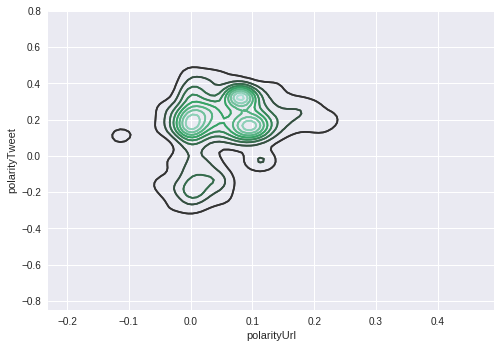

In [66]:
sb.kdeplot(dataPolar["polarityUrl"], dataPolar["polarityTweet"])
plt.show()

regardons maintenant la relation entre le ratio image/text et la polarité à la fois de l'article et du tweet

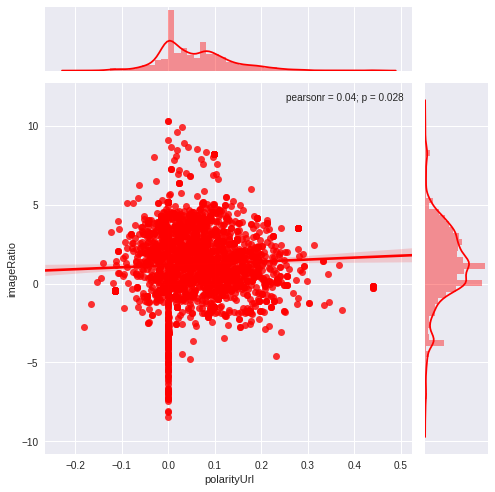

In [86]:
sb.jointplot("polarityUrl", "imageRatio", data=data, kind="reg", color="r", size=7)
plt.show()

Bof, pas bien convaiquant. Nous pourrions jeter un oeil rapide à polarité ~ liked

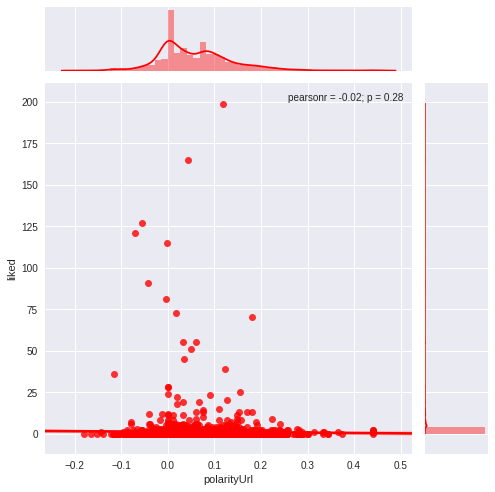

In [87]:
sb.jointplot("polarityUrl", "liked", data=data, kind="reg", color="r", size=7)
#data.plot("polarityUrl","liked" ,kind ="scatter", ylim =(1,25))
plt.show()

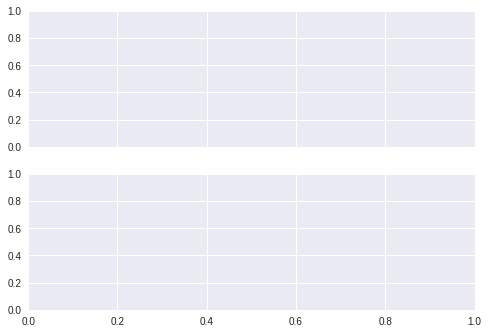

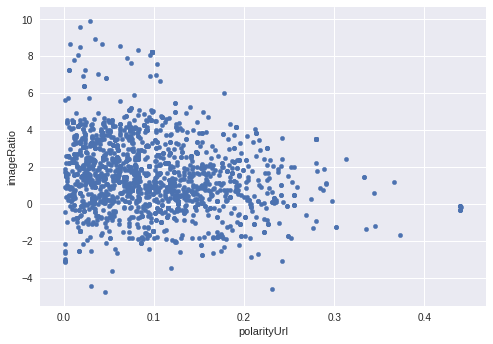

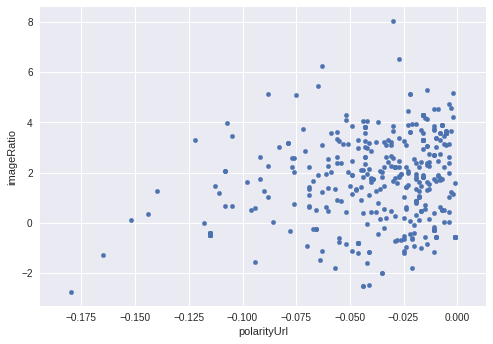

Essayons d'aller plus loin dans l'analyse du langage

In [88]:
def getAdj(x):
    adjs = []
    for i in x:
        if (i[1] == 'JJ'):
            adjs.append(i[0])
    return adjs

In [90]:
data['tokenized'] = data.apply (lambda row: nltk.word_tokenize(row["text"]),axis=1)
data['posTag'] = data.apply (lambda row: nltk.pos_tag(row["tokenized"]),axis=1)
data['Adj'] = data.apply (lambda row: getAdj(row["posTag"]),axis=1)
data['Adj'] = data['Adj'].apply(pd.Series).astype(str)

In [97]:
def PrintMainLemmes(n, d):
    d['Adj'] = data.apply (lambda row: nltk.WordNetLemmatizer().lemmatize(row["Adj"]),axis=1)
    d['Adj'] = d['Adj'].str.lower()
    
    AdjTop = d['Adj'].value_counts().head(n)
    
    dAdj = d[d['Adj'].isin(AdjTop.index.values)]
    
    sb.boxplot(x="polarityTweet", y="Adj", data=dAdj)
    plt.suptitle('Polarity of main Lemmes (adj)', fontsize=20)
    plt.savefig('lemmes.png')
    plt.show()

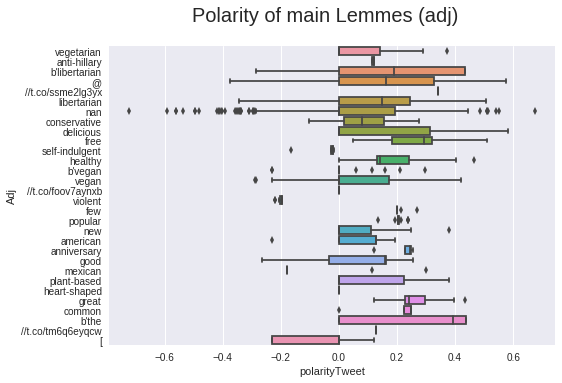

In [100]:
PrintMainLemmes(30, data)